<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwdm_support_scripts/blob/main/Elevation_Generator_using_Google_EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elevation Generator Using Google Earth Engine**
### Returns ground surface elevations for lat/long locations  

*A csv with latitudes and longitudes for each point is requird as an input. The script then samples a DEM, obtained via Google Earth Engine, at each point to obtain ground elevations, returned in a new csv.*  
**** Please note that accuracy is limited to the accuracy of the DEM. Field measured GSEs are preferable.***


## **Instructions:**
*This is a Google Colab Notebook, shared as a Github Gist. That means that you can perform operations within this notebook and download your files once you're done. Once you restart the session (e.g. refresh the page) your changes will not be saved. However, you can save a copy of this notebook using the "File" tab.*
* To use this tool, follow the instructions in the right side of each cell. 
* **To run each cell, press the play button on the left. Occasionally, the cell will require additional input after pressing the play button.**
* If an error appears, double check that all input options are correct.
* After all cells have been run, a csv file will be generated, which can be downloaded from the "Files" window on the left

In [ ]:
#@markdown ### **Run this cell and proceed**
# Install dependencies
%%capture
!pip install geopandas
!pip install dms2dec

In [ ]:
#@markdown ### **Run this cell to load packages and proceed**
# Load Libraries
%%capture
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
from google.colab import files
import ipywidgets as widgets
from dms2dec.dms_convert import dms2dec
import math
import sys

### **First, initialize Google Earth Engine**
#### Your google account needs to have access to G.E.E. so that you can receive authentication. **If you have not already registered for G.E.E., follow this link:**
https://signup.earthengine.google.com/#!/  
    
*The service is free for certain purposes, but not free for commercial purposes.*

***After receiving access to Google Earth Engine (you will receive an email confirming access), return to this page. After running the cell, you will need to follow the link in the cell.***

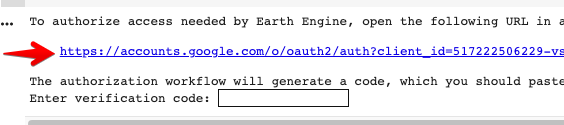

***After authorizing Google Earth Engine, you will receive an authorization token, which you should copy and paste in the box and hit the 'Enter' button.***

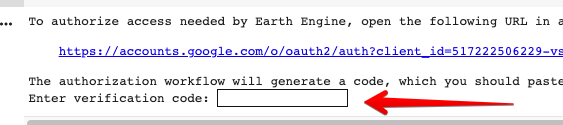

In [ ]:
#@markdown ### **Run this cell to initialize Google Earth Engine**
#@markdown ##### *Follow the prompt below after running the cell. Press enter after adding your authorization token*

# Trigger the Google Earth Engine authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

<a name="addCSV"></a>
### **Next, load csv and define headers**
##### *Upload the csv file and then pick the names of its headers. Then specify the parameters for the output.*

In [ ]:
#@markdown ### **Run this cell to load the wells file and define its headers**
#@markdown ##### *Follow the instructions on the output after running the cell.*
#@markdown ##### * If there is an existing column with some ground surface elevation measurements, be sure to pick the appropriate header. Otherwise, select "N/A"
#@markdown ##### * Don't forget to specify units

# Upload the wells CSV file into a dataframe
print("Upload your wells file:\n")
uploaded = files.upload()
wells_file = ''.join(uploaded)
wls_df = pd.read_csv(wells_file)

# Set up the widgets for the headers
wList = wls_df.columns
lat_widget = widgets.Dropdown(options=wList, layout={'width': 'max-content'}, description = "Latitude")
long_widget = widgets.Dropdown(options=wList, layout={'width': 'max-content'}, description = "Longitude")
latLongFormat_widget = widgets.Dropdown(options=['Decimal', 'DMS'], layout={'width': 'max-content'}, description = "")
units_widget = widgets.Dropdown(options=['Meters','Feet'], layout={'width': 'max-content'}, description = "Units")

# Print the widgets so that the user can specify the headers
wItems = [ lat_widget, long_widget, widgets.HBox([widgets.Label(value="Lat/Long format"), latLongFormat_widget]) ]
print("\n\nPLEASE CHOOSE THE APPROPRIATE HEADERS FROM YOUR FILE AND THE UNITS FOR THE OUTPUT:\n")
left_box = widgets.VBox(wItems)
right_box = widgets.VBox([units_widget])
widgets.GridBox([left_box, right_box], layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

In [ ]:
#@markdown ### **Run this cell to retrieve values from dropdown menus**

# Retrieve values
latitude, longitude = lat_widget.value, long_widget.value
latlongFormat, units = latLongFormat_widget.value, units_widget.value

# Convert lat/long, if necessary
if latlongFormat == "DMS":
  wls_df[["long_dec", "lat_dec"]] = wls_df[[longitude, latitude]].applymap(lambda x: dms2dec(x))
  longitude, latitude = "long_dec", "lat_dec"
print('Values Loaded! Proceed to next cell')

### **Finally, run the remainder of cells**

In [ ]:
#@markdown ### **Run cell to create a dataframe and initialize variables**

# Read the file into a df
pts_df = pd.read_csv(wells_file)
# GEE has a max of 5000 elements. If the file has greater than 5000 wells, we need to break it up
numBlocks = math.ceil(len(pts_df) / 5000)

# This sets the DEMs from Google Earth Engine
dem = ee.Image("NASA/NASADEM_HGT/001")
dem2 = ee.Image("JAXA/ALOS/AW3D30/V2_2")

# Initiate lists and dictionary
elev_values, elev_values2 = [], []
long_values, lat_values = [], []
long_values2, lat_values2 = [], []
dfDict = {}
print('Success!')

In [ ]:
#@markdown ### **Run cell to sample elevations from Google Earth Engine DEMs**
#@markdown ##### *Two different DEMs will be sampled and the average from the two will be calculated for each well*

for x in range(numBlocks):
  print("\rLoading... " + str(round(x/numBlocks*100)) + "%", end = '')
  iterRange = [x*5000, (x+1)*5000]
  dfDict["df{0}".format(x)] = pts_df[iterRange[0]:iterRange[1]]
  coordsZip = [(x,y) for x, y in zip(dfDict["df{0}".format(x)][longitude], dfDict["df{0}".format(x)][latitude])]
  # make points from nodes
  points = [ee.Geometry.Point(coord) for coord in coordsZip]
  # make features from points (name by list order)
  feats = [ee.Feature(p, {'name': 'node{}'.format(i)}) for i, p in enumerate(points)]
  # make a featurecollection from points
  fc = ee.FeatureCollection(feats)
  # extract points from DEM
  reducer = ee.Reducer.first()
  data = dem.reduceRegions(fc, reducer.setOutputs(['elevation']), 30)
  data2 = dem2.reduceRegions(fc, reducer.setOutputs(['AVE_DSM']), 30)
  # loop through each feature to get elevations
  for feat in data.getInfo()['features']:
    elev = feat['properties']['elevation']
    long, lat = feat['geometry']['coordinates']
    elev_values.append(elev)
    long_values.append(long)
    lat_values.append(lat)
  print('\rLoading... ' + str(round((x+0.5)/numBlocks*100)) + '%', end='')
  for feat in data2.getInfo()['features']:
    elev2 = feat['properties']['AVE_DSM']
    long2, lat2 = feat['geometry']['coordinates']
    elev_values2.append(elev2)
    long_values2.append(long2)
    lat_values2.append(lat2)
    # Source: https://gis.stackexchange.com/questions/385417/get-elevation-for-multiple-lon-and-lat-using-earth-engine-in-python
print("\rDone!")

In [ ]:
#@markdown ### **Run this cell to validate the data and convert units, if necessary**
if all(pts_df[longitude]== long_values) and all(pts_df[longitude] == long_values2) and all(pts_df[latitude] == lat_values) and all(pts_df[latitude] == lat_values2):
  print("Validated")
  pts_df['NASA_GSE'] = elev_values
  pts_df['AW3D_GSE'] = elev_values2
  if units == 'Feet':
    pts_df['NASA_GSE'] = pts_df['NASA_GSE']*3.28084
    pts_df['AW3D_GSE'] = pts_df['AW3D_GSE']*3.28084
  pts_df['Avg_GSE'] = pts_df[['NASA_GSE', 'AW3D_GSE']].mean(axis=1)
pts_df

In [ ]:
#@markdown ### **Run the cell to save the csv file**

#elevPts_df = pts_df.drop(['NASA_GSE','AW3D_GSE'], axis=1)
#elevPts_df.rename( {'Avg_GSE':'DEM_GSE'}, axis='columns', inplace=True)

pts_df.to_csv (wells_file[:-4]+"_with_Elev.csv", index = None, header=True)
print('Success!')

## **Retrieve Files**
#### Check the 'Files' panel on the left for your new files. Click the three dots next to the file to download it.
*(Hit the refresh button if you do not see the new file initially. It will have "_with_Elev" appended to the end)*

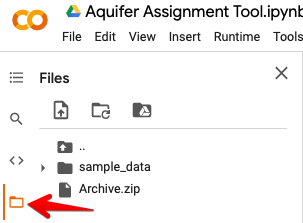

[Add a new file](#addCSV)